In [1]:
import torch
import lightning as L

from gpsr.diagnostics import ImageDiagnostic

from gpsr.modeling import GPSR, GPSRQuadScanLattice
from gpsr.train import LitGPSR
from gpsr.beams import NNParticleBeamGenerator
from gpsr.datasets import FourDReconstructionDataset

In [ ]:
# create diagnostic screen:
bins = torch.linspace(-30, 30, 200) * 1e-3
bandwidth = (bins[1] - bins[0]) / 2
screen = ImageDiagnostic(bins, bins, bandwidth)

# create diagnostics lattice:
p0c = 43.36e6  # reference momentum in eV/c
gpsr_lattice = GPSRQuadScanLattice(l_quad=0.1, l_drift=1.0, diagnostic=screen)

# load training dataset
train_dset = torch.load("example_data/example_datasets/reconstruction_4D_train.dset", weights_only=False)

In [10]:
train_dset.parameters.shape

torch.Size([1, 10])

In [9]:
train_dset.observations[0].shape

torch.Size([10, 200, 200])

In [3]:
train_dset.observations[0].shape
full_batch_size = train_dset.observations[0].shape[0]
print(f"Full batch size: {full_batch_size}")

Full batch size: 10


In [4]:
gpsr_model = GPSR(NNParticleBeamGenerator(10000, p0c), gpsr_lattice)
train_loader = torch.utils.data.DataLoader(train_dset, batch_size=full_batch_size)

litgpsr = LitGPSR(gpsr_model)
logger = L.pytorch.loggers.TensorBoardLogger(
    ".",
)
trainer = L.Trainer(max_epochs=500, logger=logger)
trainer.fit(model=litgpsr, train_dataloaders=train_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type | Params | Mode 
--------------------------------------------
0 | gpsr_model | GPSR | 1.1 K  | train
--------------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode
/opt/homebrew/Caskroom/miniforge/base/envs/gpsr/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.
/opt/homebrew/Caskroom/miniforge/base/envs/gpsr/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging int

Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 16.01it/s, v_num=32]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 14.27it/s, v_num=32]


In [5]:
reconstructed_beam = litgpsr.gpsr_model.beam_generator()

## Evaluate model on test samples to compare predictions

In [6]:
test_dset = torch.load("example_data/example_datasets/reconstruction_4D_test.dset", weights_only=False)
test_pred = gpsr_model(test_dset.parameters)[0].detach()
test_pred_dset = FourDReconstructionDataset(test_dset.parameters, test_pred, bins)

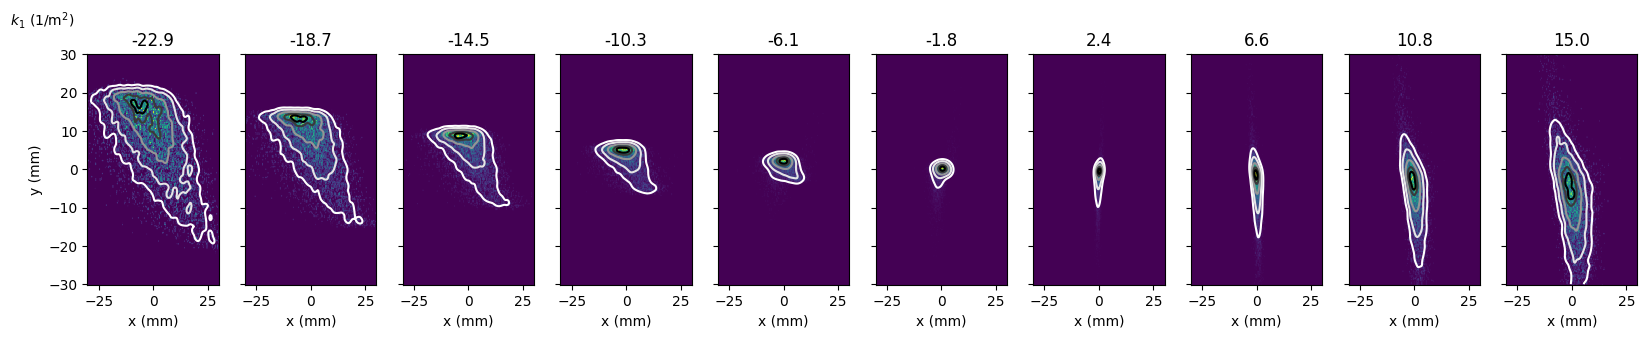

In [7]:
fig, ax = test_dset.plot_data(overlay_data=test_pred_dset)
fig.set_size_inches(20, 3)

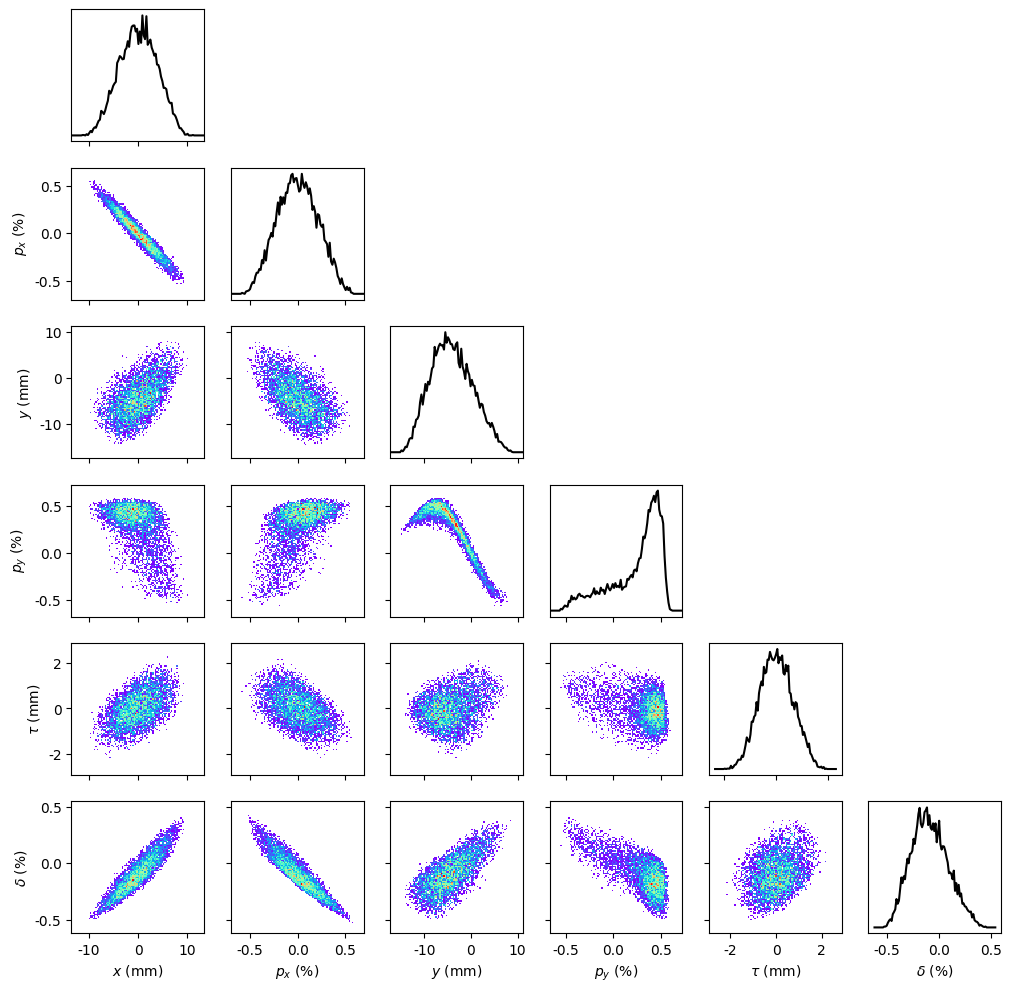

In [8]:
reconstructed_beam.plot_distribution();